In [1]:
from differences import ATTgt
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
from panel_utilities import get_value_variable_names, prepare_df_for_DiD
from stats_utilities import select_controls, test_balance, produce_summary_statistics
from figure_utilities import aggregate_by_event_time_and_plot, aggregate_by_time_and_plot
import pandas as pd



# Store paths.
analysis='group_0_crimes_500m'
INPUT_DATA = "../../data/03_cleaned/crime_analysis_monthly.parquet"
OUTPUT_FIGURES = f"../../output/group_0_crimes_warm_500m/figures"
OUTPUT_TABLES = f"../../output/group_0_crimes_warm_500m/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_parquet(INPUT_DATA)

In [2]:
# Convert weekly panel to biweekly panel.
treatment_date_variable = 'latest_docket_month'
df = df.dropna(subset=treatment_date_variable)

# Generate value vars list and month to int dictionaries.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [3]:
pre_pandemic_months = ['2019-04'
                       '2019-05'
                       '2019-06',
                       '2019-07',
                       '2019-08',
                       '2019-09',
                       '2019-10',
                       '2019-11',
                       '2019-12',
                       '2020-01',
                       '2020-02',
                       '2020-03']


df = df.loc[df['latest_docket_month'].isin(pre_pandemic_months), :]

In [4]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                                                  
                                                 \emph{Independent Variable}                                      
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_0_crimes_500m       1.018684e-204   
                                                 pre_treatment_change_in_group_0_crimes_500m       6.367288e-11   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                4.434623e-01   
                                                 job_density_2013                                  4.128610e-37   
                                                 med_hhinc2016                                     5.628575e-01   
                                                 poor_share2010                                    9.592824e-05   
                                                 popdensity2010                                    1.749052e-06   
Panel C: Case Initiation                         for_cause                                         5.111389e-02   
                                                 no_cause                                          8.190438e-02   
                                                 non_payment                                       5.962984e-03   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                          7.678061e-01   
                                                 hasAttyP                                          8.415581e-01   
                                                 isEntityD                                         3.314166e-05   
                                                 isEntityP                                         2.618711e-01   

                                                                                                        
                                                                                                        
                                                 \emph{Independent Variable}                            
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_0_crimes_500m   0.883948  
                                                 pre_treatment_change_in_group_0_crimes_500m  0.602813  
Panel B: Census Tract Characteristics            frac_coll_plus2010                           0.065969  
                                                 job_density_2013                             0.151709  
                                                 med_hhinc2016                                0.031014  
                                                 poor_share2010                               0.000039  
                                                 popdensity2010                               0.796100  
Panel C: Case Initiation                         for_cause                                    0.007188  
                                                 no_cause                                     0.588931  
                                                 non_payment                                  0.017316  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                     0.037884  
                                                 hasAttyP                                     0.194854  
                                                 isEntityD                                    0.067403  
                                                 isEntityP                                    0.025442

In [5]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                             Cases Won by Plaintiff   
Panel A Total Crime Incidents, 2017                     1208.600462   
        Change in Crime Incidents, 2017-2019            -160.325635   
Panel B Job density, 2013                              18611.940391   
        Poverty rate, 2010                                 0.267113   
        Population density, 2010                       23288.997077   
Panel C Filing for nonpayment                              0.792148   
Panel D Defendant is entity                                0.025404   

                                             Difference in Cases Won by Defendant  \
                                                                       Unweighted   
Panel A Total Crime Incidents, 2017                                      7.915341   
        Change in Crime Incidents, 2017-2019                            -8.993455   
Panel B Job density, 2013                                             4656.909815   
        Poverty rate, 2010                                              -0.044690   
        Population density, 2010                                      -271.854486   
Panel C Filing for nonpayment                                           -0.069444   
Panel D Defendant is entity                                              0.018484   

                                                                               
                                              \emph{p}     Weighted  \emph{p}  
Panel A Total Crime Incidents, 2017           0.883948   -89.243778  0.051476  
        Change in Crime Incidents, 2017-2019  0.602813     9.439942  0.566638  
Panel B Job density, 2013                     0.151709    -4.926964  0.998664  
        Poverty rate, 2010                    0.000039    -0.033747  0.001163  
        Population density, 2010              0.796100 -1847.818316  0.050408  
Panel C Filing for nonpayment                 0.017316    -0.081028  0.005552  
Panel D Defendant is entity                   0.067403     0.003655  0.687798

In [6]:
# Generate indicators for missing data.

# missing_indicators = add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [7]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='2W', base_period='universal')
result = att_gt.fit(formula=analysis, control_group='not_yet_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 460/460 [00:05<00:00, 88.69it/s] 


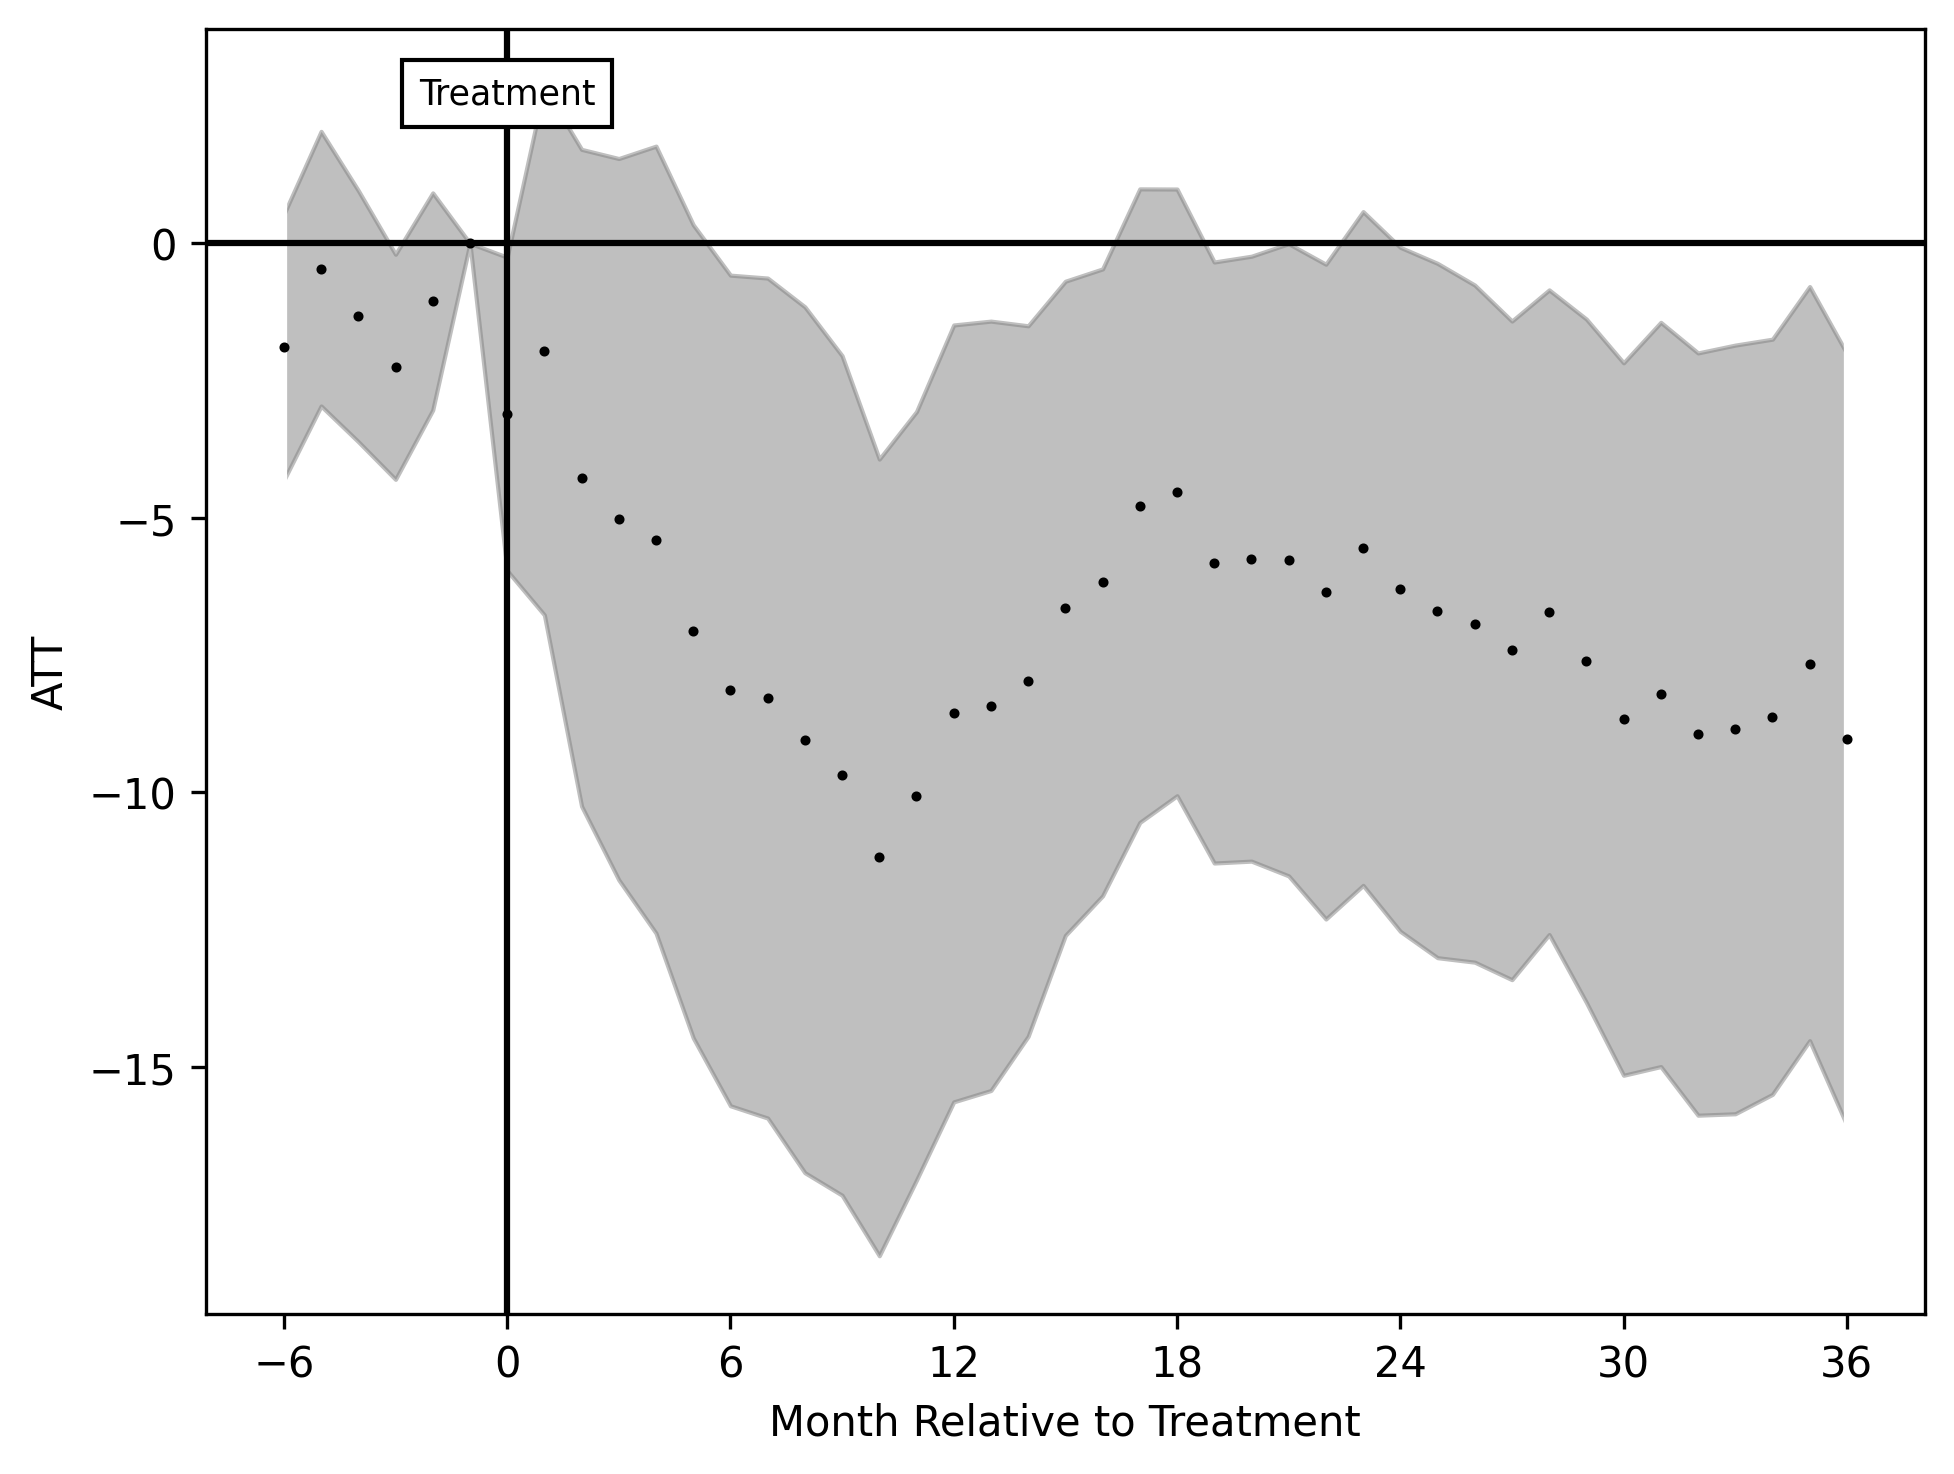

In [8]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-6, end_period=36,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

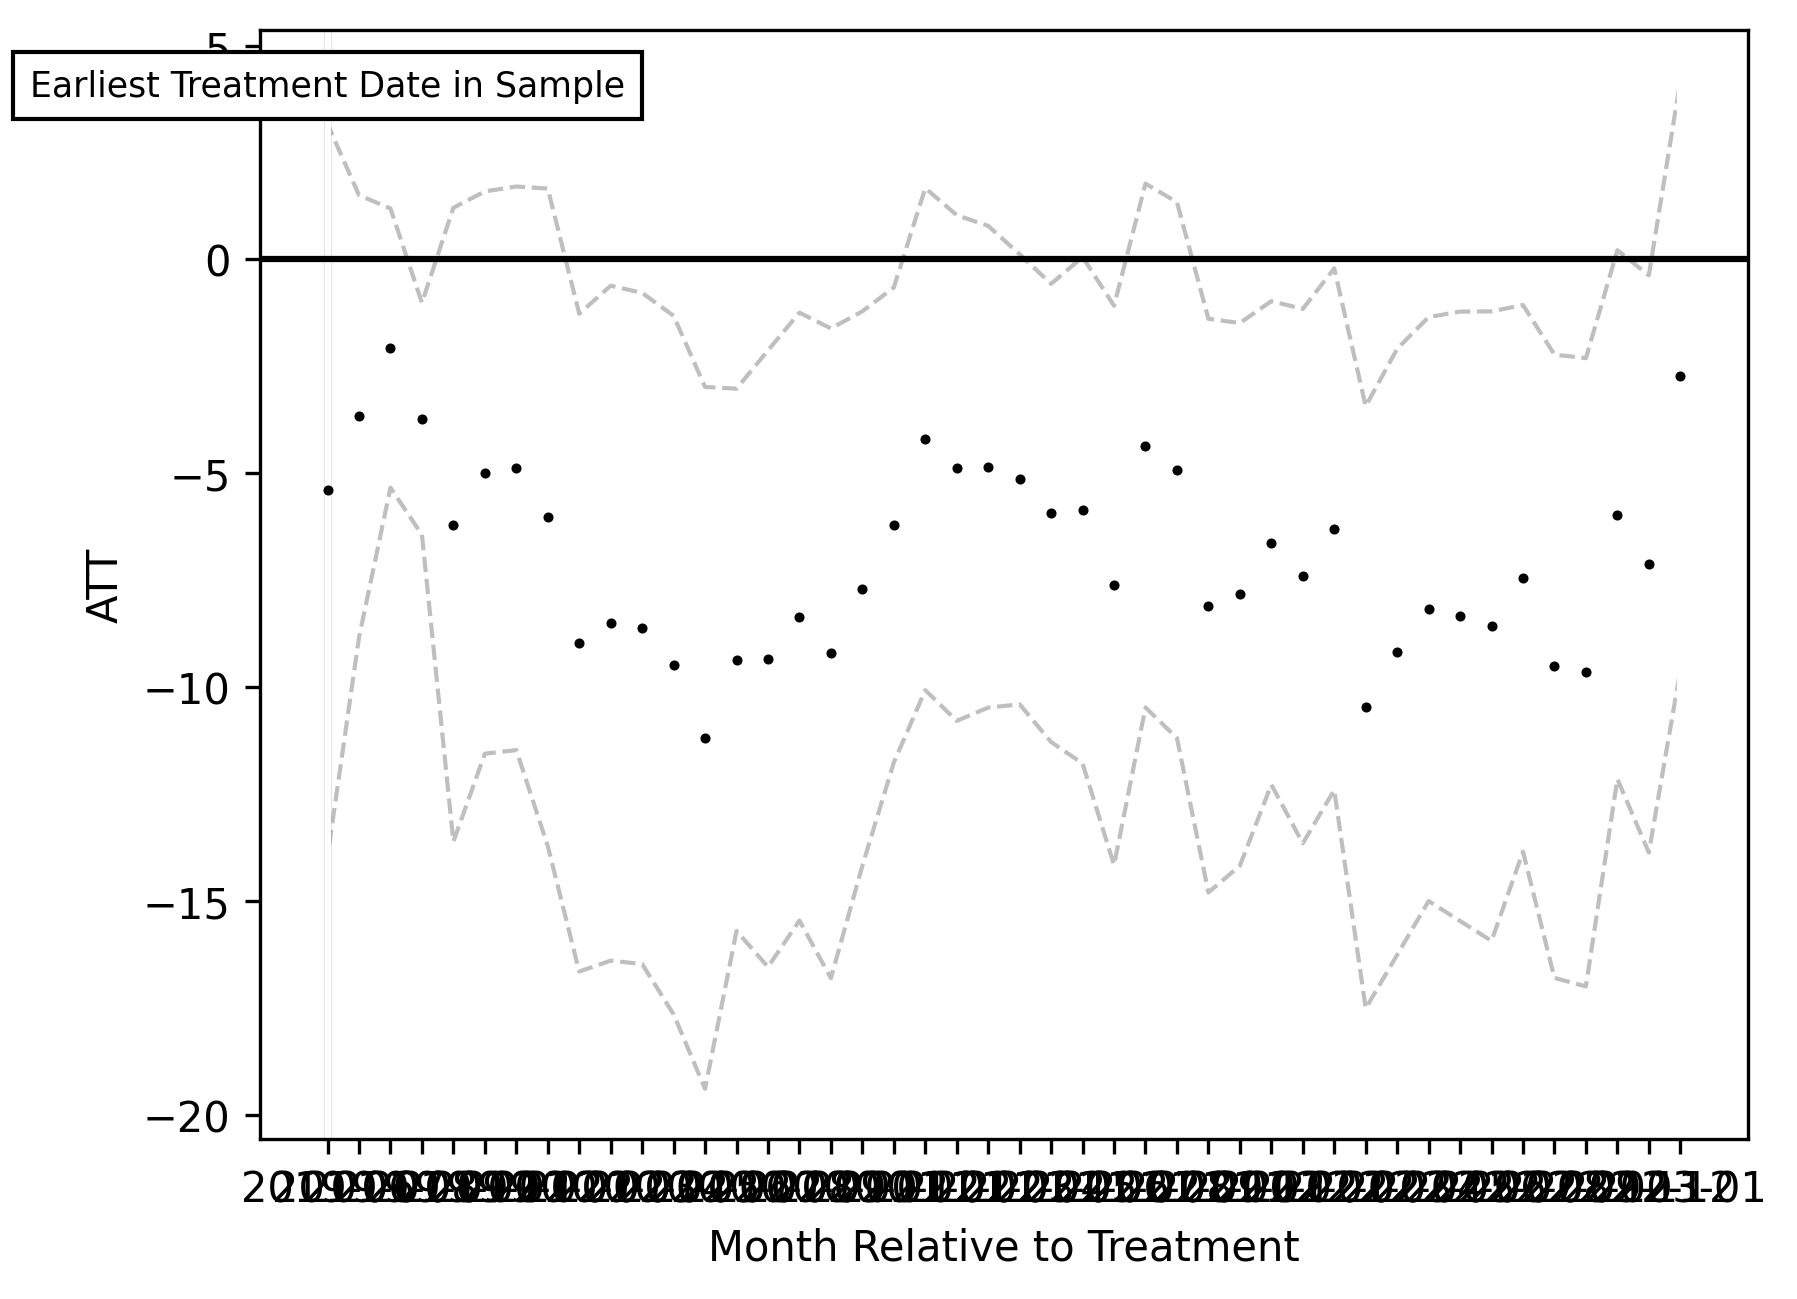

In [9]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="")

In [10]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='M', base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='not_yet_treated', n_jobs=-1, progress_bar=True)

Computing ATTgt [workers=10]  100%|████████████████████| 460/460 [00:11<00:00, 38.47it/s]


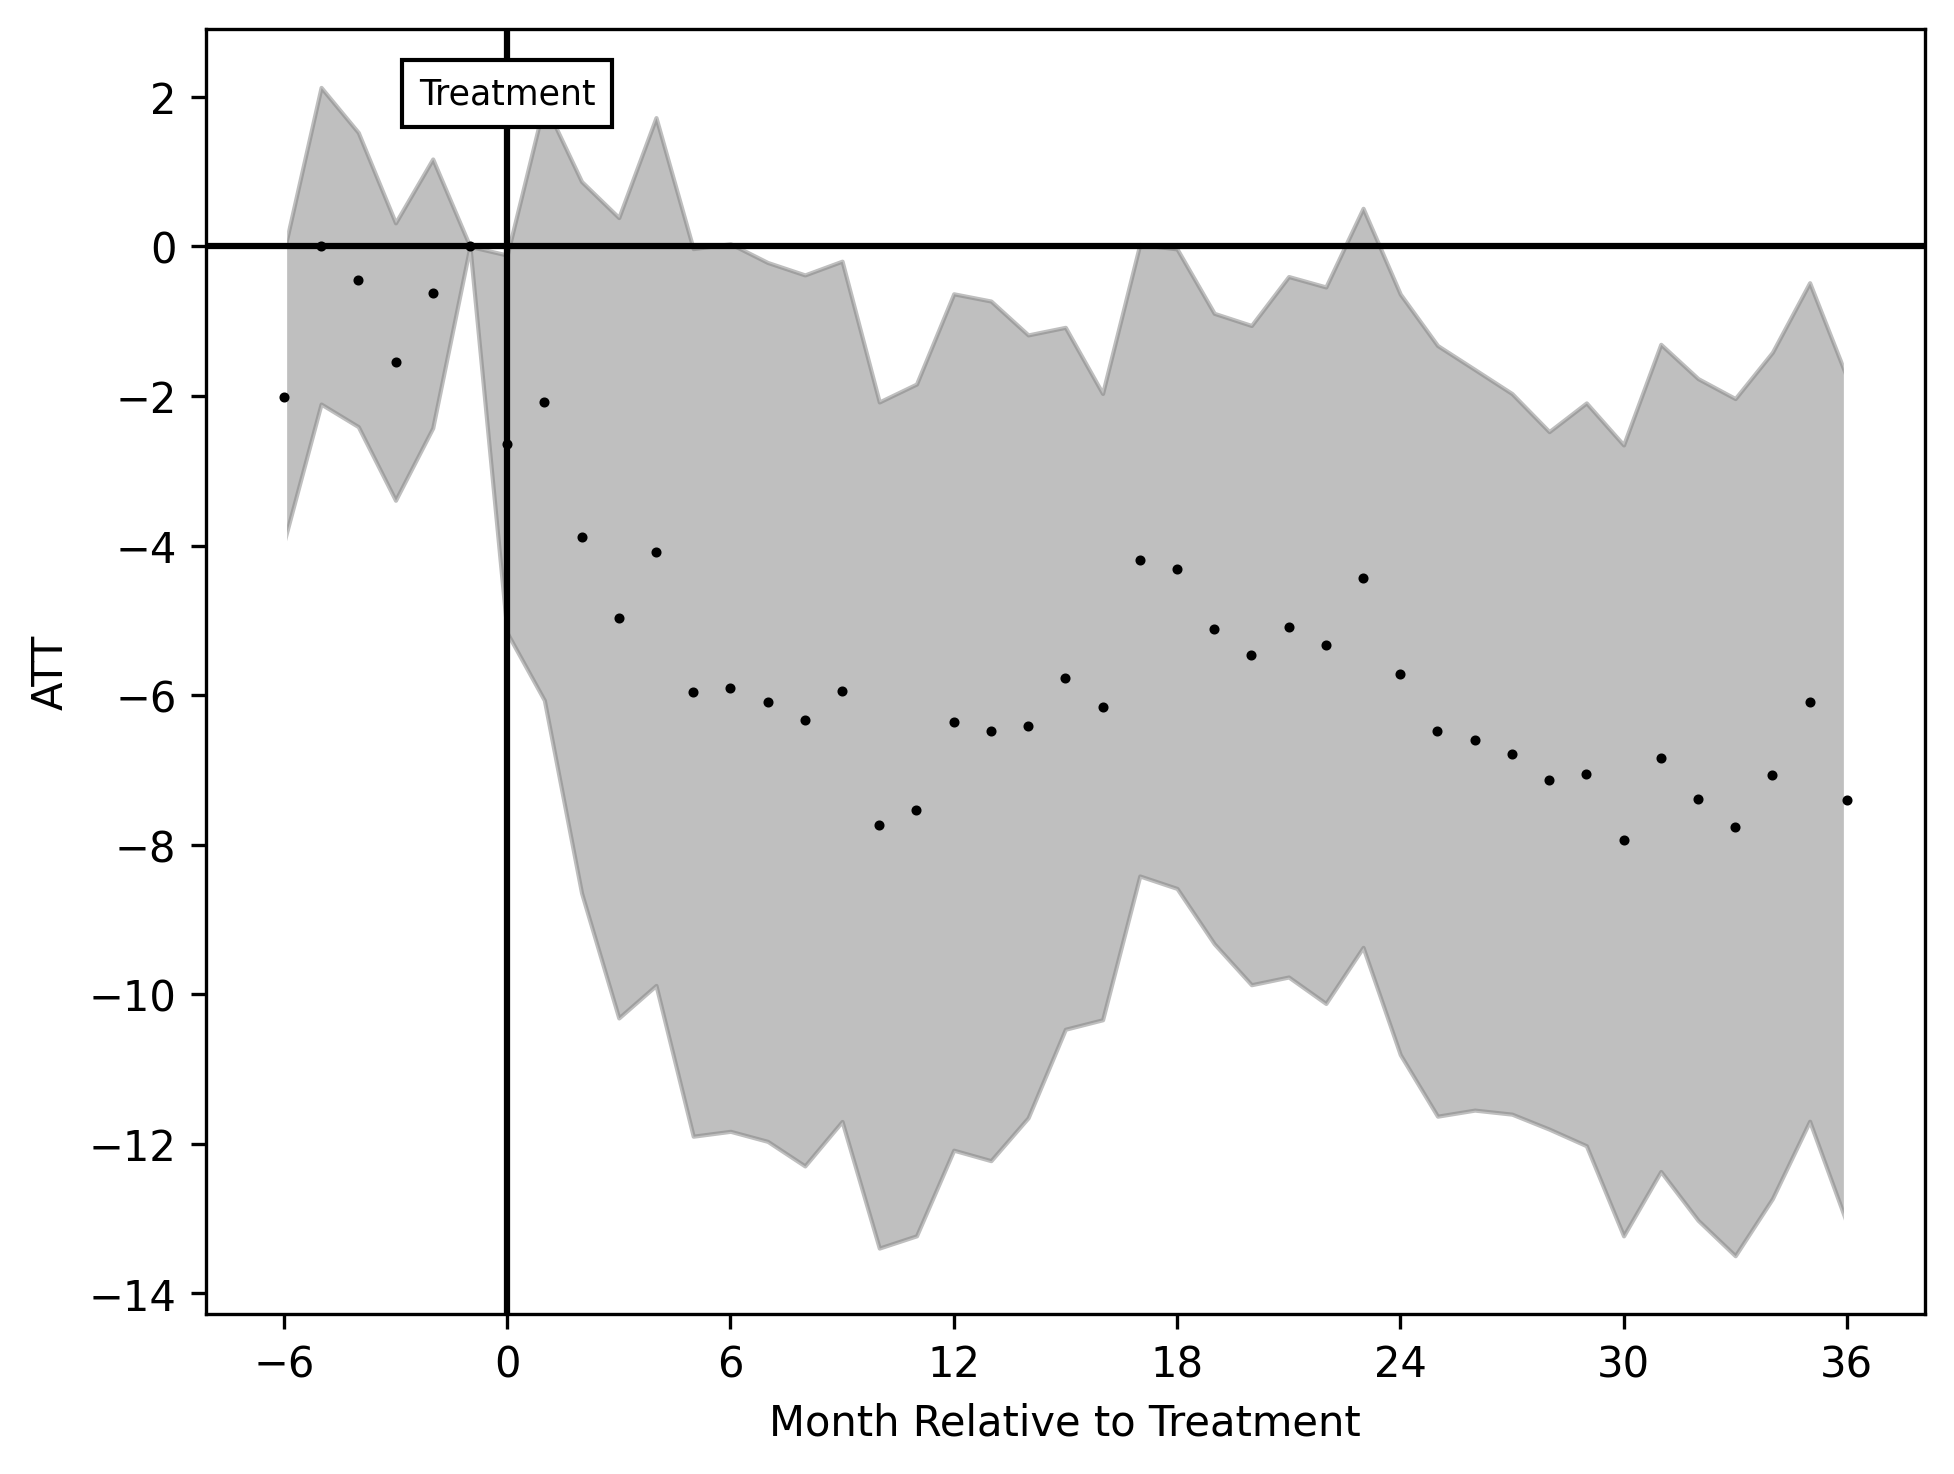

In [11]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-6,
                                 end_period=36,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

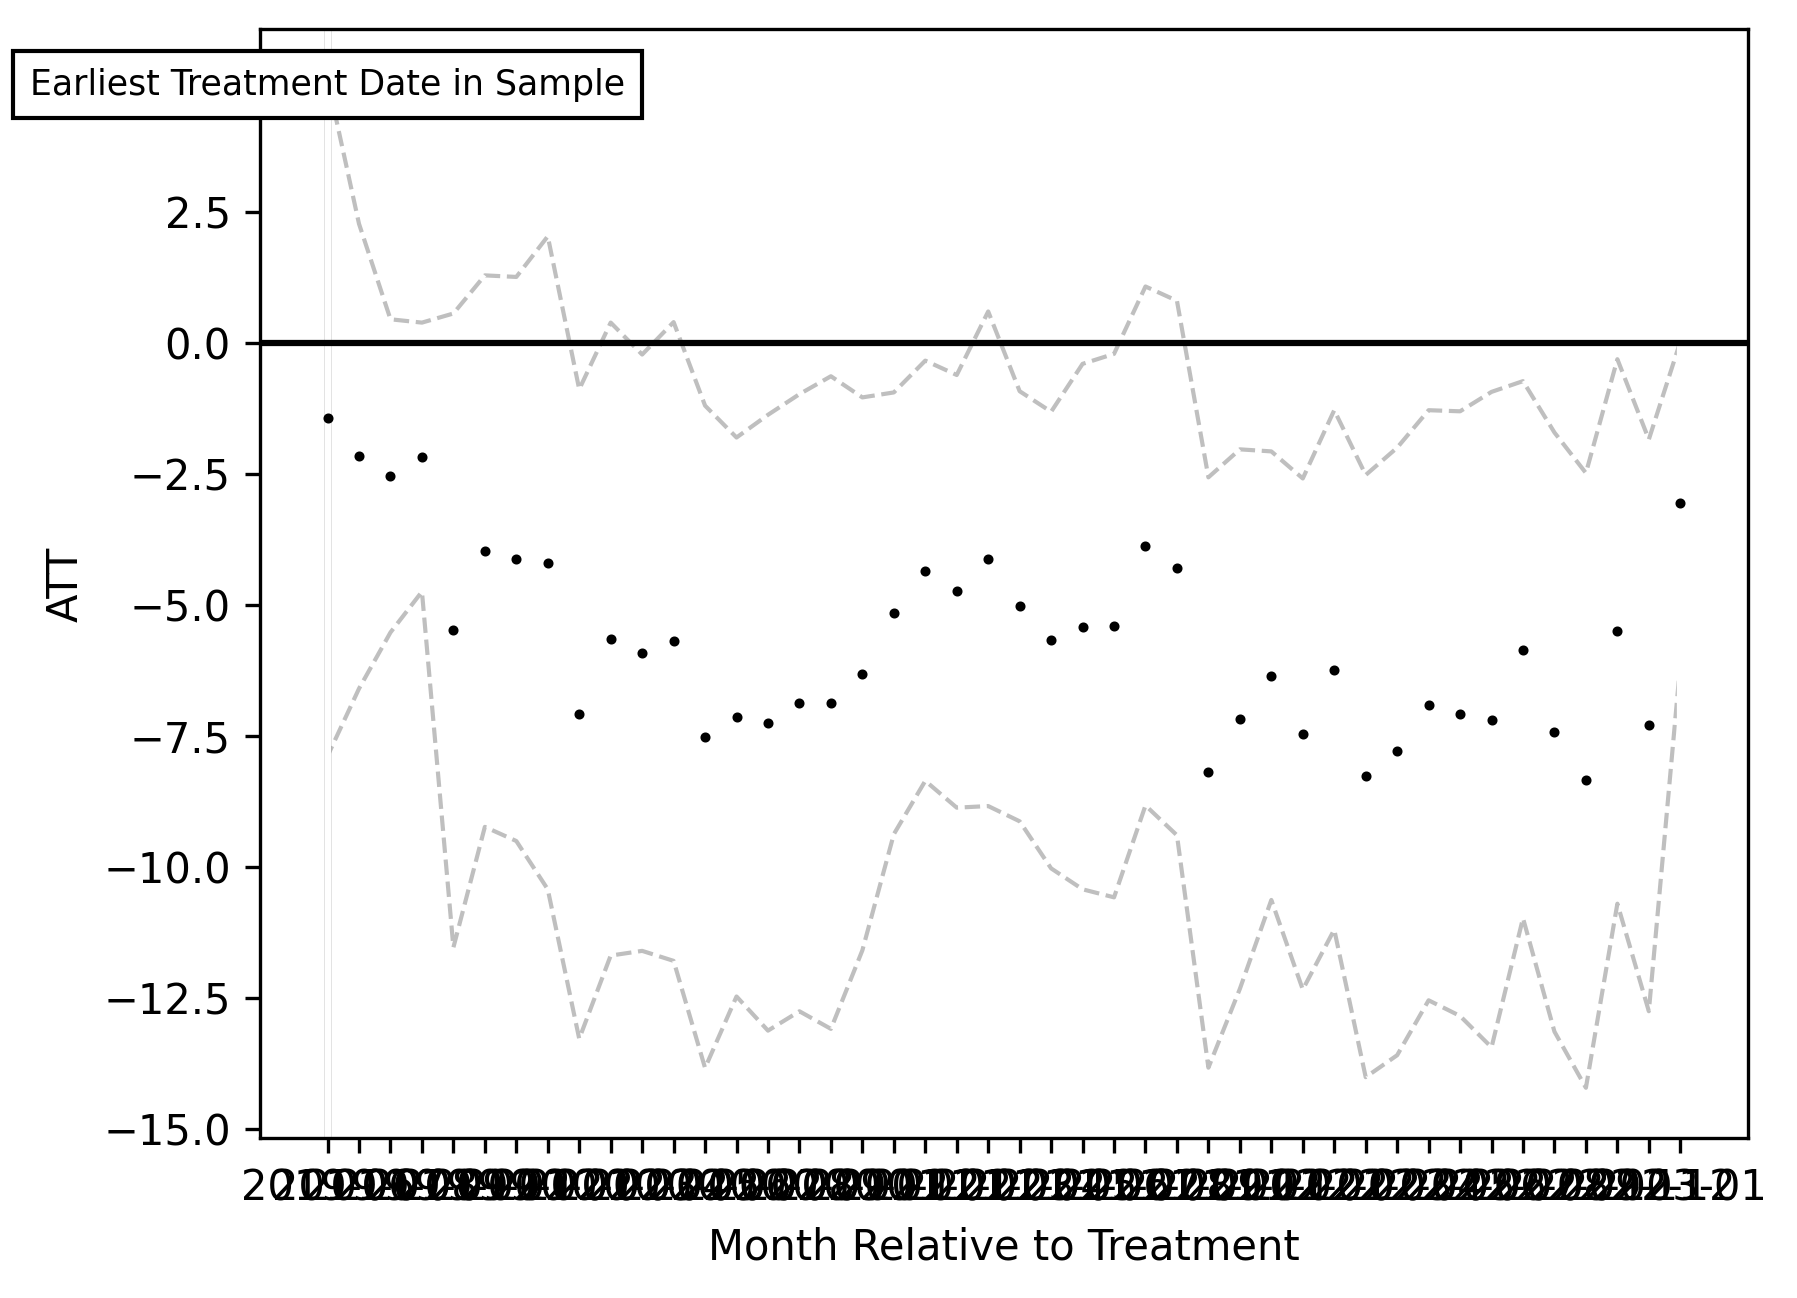

In [12]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="")